<a href="https://colab.research.google.com/github/willdphan/video-vpr/blob/main/Goffs_SeqNet_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Main Pipeline

Load and unzip data from Google Drive.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
!apt-get install p7zip-full
!7z x "/content/drive/My Drive/Notebooks/Datasets/Habi.tar" -o"/content"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/Notebooks/Datasets/                                                     1 file, 5772839936 bytes (5506 MiB)

Extracting archive: /content/drive/My Drive/Notebooks/Datasets/Habi.tar
  2% 1024 Open                5% 2048 Open                8% 3072 Open               11% 4096 Open               14% 5

Set some hyperparameters for quick use.

In [34]:
#HYPER-PARAMETERS PART
# options = ["Resnet18", "Resnet34", "Resnet50", "Resnet101","Resnet152", "VGG16", "VGG16_BN", "VGG19", "InceptionV3", "MobileNetV3Large", "LargeEfficientNet"]
# ["max", "middle", int]
k_const = 2
model_choice = "VGG16"
VLAD_CLUSTERS = 128
num_epochs = 10
K_RETRIEVE = 5
num_frames = 5
batch_size = 16

skip_rate = 5 #sample rate

train_dir = "/content/Habi/train/Goffs"
val_dir = "/content/Habi/train/Goffs"


Set device.

In [35]:
import torch
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Original SeqNet Model

In [36]:
import torch
import torch.nn as nn
import numpy as np
import os
import torch.nn.functional as F
from tqdm import tqdm
from torch import nn, optim

outDims = 4096

class seqNet(nn.Module):
    def __init__(self, inDims, outDims, seqL, w=5):

        super(seqNet, self).__init__()
        self.inDims = inDims
        self.outDims = outDims
        self.w = w
        self.conv = nn.Conv1d(inDims, outDims, kernel_size=self.w)

    def forward(self, x):

        if len(x.shape) < 3:
            print("length is less than 3")
            x = x.unsqueeze(1) # convert [B,C] to [B,1,C]

        x = x.permute(0,2,1) # from [B,T,C] to [B,C,T]
        seqFt = self.conv(x)
        seqFt = torch.mean(seqFt,-1)

        return seqFt

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class L2Norm(nn.Module):
    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, input):
        return F.normalize(input, p=2, dim=self.dim)

def get_model(encoder_dim):
    model = nn.Module()

    seqFt = seqNet(encoder_dim, outDims, num_frames, 3)
    model.add_module('pool', nn.Sequential(*[seqFt, Flatten(), L2Norm()]))

    model = model.to(device)

    return model

Load the generated feature vectors from `Goffs_netvlad_pickle.pkl` file.

In [37]:
import pickle
with open('Goffs_netvlad_pickle.pkl', 'rb') as file:
    train_data = pickle.load(file)

    # Convert each tensor in the list to a NumPy array after moving to CPU
    train_data = [tensor.cpu() if torch.is_tensor(tensor) else tensor for tensor in train_data]

    model_train = train_data
    print(len(model_train))


# print(X_train)
model_train = np.array(model_train)

with open('Goffs_netvlad_pickle.pkl', 'rb') as file:
    val_data = pickle.load(file)
    val_data = [tensor.cpu() if torch.is_tensor(tensor) else tensor for tensor in val_data]

    model_val = val_data
    print(len(model_val))

print(type(model_val))

# Convert all tensors in the list to NumPy arrays

14959


<ipython-input-37-49518ccfea29>:13: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  model_train = np.array(model_train)
<ipython-input-37-49518ccfea29>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model_train = np.array(model_train)


14959
<class 'list'>


Reshape tensors into certain format usable for model.

`isinstance` function in Python is used to check if an object is an instance of a particular class or a tuple of classes. In the context of your code:

In [38]:
train_indices = [i for i in range(0, 10471 - num_frames + 1, skip_rate)]
model_train_processed = [model_train[i:i + num_frames] for i in train_indices if len(model_train[i:i + num_frames]) == num_frames]

# Convert each subsequence to a numpy array
model_train_arrays = []
for subseq in model_train_processed:
    # checks if first element of each subsequence is instance of torch.Tensor
    if isinstance(subseq[0], torch.Tensor):
        # Convert tensors to numpy arrays
        model_train_arrays.append(np.stack([t.numpy() for t in subseq], axis=0))
    else:
        # Convert lists or other types to numpy arrays
        model_train_arrays.append(np.array(subseq, dtype=np.float32))

# Stack the arrays
model_train_stacked = np.stack(model_train_arrays)

# Convert to PyTorch tensor and reshape
model_train_tensor = torch.tensor(model_train_stacked, device=device).view(-1, 5, 4096, 1)
print(len(model_train_tensor))
print(model_train_tensor.shape)

val_indices = [i for i in range(10471, 14959 - num_frames + 1, skip_rate)]
model_val_processed = [model_val[i:i + num_frames] for i in val_indices if len(model_val[i:i + num_frames]) == num_frames]

# Convert each subsequence to a numpy array
model_val_arrays = []
for subseq in model_val_processed:
    if isinstance(subseq[0], torch.Tensor):
        # Convert tensors to numpy arrays
        model_val_arrays.append(np.stack([t.numpy() for t in subseq], axis=0))
    else:
        # Convert lists or other types to numpy arrays
        model_val_arrays.append(np.array(subseq, dtype=np.float32))

# Stack the arrays
model_val_stacked = np.stack(model_val_arrays)

# Convert to PyTorch tensor and reshape
model_val_tensor = torch.tensor(model_val_stacked, device=device).view(-1, 5, 4096, 1)
print(len(model_val_tensor))
print(model_val_tensor.shape)
print(model_val[0].shape)

2094
torch.Size([2094, 5, 4096, 1])
897
torch.Size([897, 5, 4096, 1])
torch.Size([1, 4096])


Set KD Tree Threshold

In [39]:
def kdtree_threshold(kdtree, curr_idx, X, Y, mode = "training", radius = 0.5):                                                                                      #return (anchor,pos,neg)
    chosen_radius = 7.5

    idx, dists = kdtree.query_radius(Y[curr_idx].reshape(1,-1), r = chosen_radius, count_only= False, return_distance = True)
    idx = idx[0].reshape(-1,)
    dists = dists[0].reshape(-1,)
    idx = idx[np.argsort(dists)][1:]
    dists = dists[np.argsort(dists)][1:]
    pos_masks = np.where(dists <= radius)[0]


    if pos_masks.size < 1:
        return kdtree_threshold(kdtree, curr_idx, X, Y, mode = mode, radius = radius + 0.2)

    if mode == "training":
        pos_index = idx[np.random.choice(pos_masks)]

        neg_masks = np.where(dists >= radius + 1.0)[0]
        neg_index = idx[np.random.choice(neg_masks)]

        # print("kdtree returns: ", torch.stack([X[curr_idx], X[pos_index], X[neg_index]]).to(device).shape)

        return torch.stack([X[curr_idx], X[pos_index], X[neg_index]]).to(device)

    elif mode == "metrics":
        pos_index = idx[pos_masks]

        return pos_index

Function for loading and concatenating pose data from multiple .mat files located in a structured directory format.

Allows selective retrieval of this data based on provided indices, which is useful for separating training and validation datasets.

In [40]:
import scipy.io as sio
def get_pos(root_dir,indicies):
    run_dirs = [run_dir for run_dir in os.listdir(root_dir) if run_dir.startswith('run_')]
    run_dirs.sort()

    print(run_dirs)
    data_list = []

    # Loop over the run directories
    for run_dir in run_dirs:
        # Check if the directory name starts with "run_"
        if run_dir.startswith('run_'):
            # Construct the path to the gt_pose.mat file in the current run directory
            mat_path = os.path.join(root_dir, run_dir, 'gt_pose.mat')

            # Print the path of the current file
            print(mat_path)

            # Load the pose data from the mat file
            pose_data = sio.loadmat(mat_path)['pose']

            # Append the pose data to the list
            data_list.append(pose_data)
    # concatenate all the pose data into a single array
    all_data = np.concatenate(data_list, axis=0)
    all_data = all_data[indicies]
    return all_data

train_data = get_pos(train_dir,train_indices)
val_data = get_pos(val_dir,val_indices)

print(len(train_data),len(model_train))
print(len(val_data),len(model_val))

['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6']
/content/Habi/train/Goffs/run_0/gt_pose.mat
/content/Habi/train/Goffs/run_1/gt_pose.mat
/content/Habi/train/Goffs/run_2/gt_pose.mat
/content/Habi/train/Goffs/run_3/gt_pose.mat
/content/Habi/train/Goffs/run_4/gt_pose.mat
/content/Habi/train/Goffs/run_5/gt_pose.mat
/content/Habi/train/Goffs/run_6/gt_pose.mat
['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6']
/content/Habi/train/Goffs/run_0/gt_pose.mat
/content/Habi/train/Goffs/run_1/gt_pose.mat
/content/Habi/train/Goffs/run_2/gt_pose.mat
/content/Habi/train/Goffs/run_3/gt_pose.mat
/content/Habi/train/Goffs/run_4/gt_pose.mat
/content/Habi/train/Goffs/run_5/gt_pose.mat
/content/Habi/train/Goffs/run_6/gt_pose.mat
2094 14959
897 14959


Import `KDTree` to create KD-tree for both `val_data` and `train_data`

Enable efficient nearest-neighbor searches within the training and validation datasets, respectively.

In [41]:
from sklearn.neighbors import KDTree
kdtree_train = KDTree(train_data, metric = "euclidean")
kdtree_val = KDTree(val_data, metric = "euclidean")

In the histogram, "frequency" refers to how many data points (from your entire dataset) have a specific "number of neighbors within radius."

Ex: if it shows a frequency of 10 for the neighbor count of 5, it means that there are 10 points in your dataset which each have exactly 5 neighbors within the specified radius.

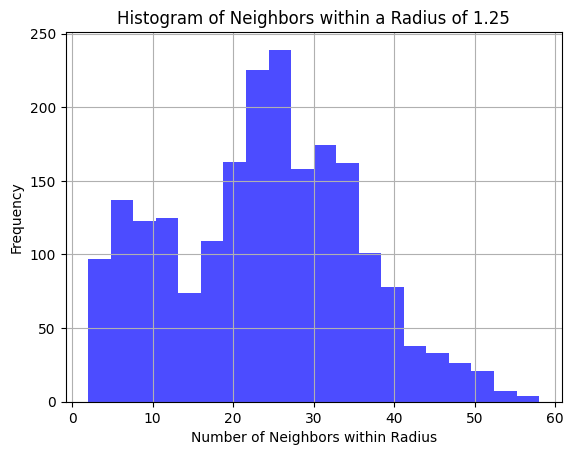

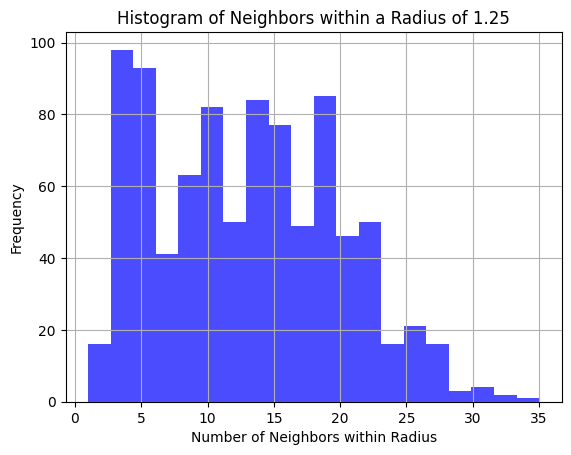

In [42]:
import matplotlib.pyplot as plt

def plot_gt_histogram(kdtree, data, chosen_radius=1.25):
    idx, dists = kdtree.query_radius(data[:], r=chosen_radius, count_only=False, return_distance=True)
    neighbor_counts = [len(neighbors) for neighbors in idx]

    # Histogram of neighbor counts
    plt.hist(neighbor_counts, bins=20, color='blue', alpha=0.7)
    plt.xlabel('Number of Neighbors within Radius')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Neighbors within a Radius of {chosen_radius}')
    plt.grid(True)
    plt.show()

plot_gt_histogram(kdtree_train,train_data)
plot_gt_histogram(kdtree_val,val_data)

`plot_gt` function visualizes the neighbor counts for each data point in your dataset, helping understand the distribution and density of points within a given radius.

Useful for identifying points that are in dense areas (with many neighbors) versus those in sparse areas (with few or no neighbors).

Ex: Trees indexed from 0 to 30 have high neighbor counts, say around 15-20 neighbors each. This suggests these trees are in a densely packed part of the forest.

[1309 1046  799   96 1687 1150 1842 1923 1577 1747 1441  180 1624  467
 1843 1151 1045 1308 1625 1442  181 1479 1688 1748 1924  800   97 1578
 1623 1044 1746 1307]
2094
2094


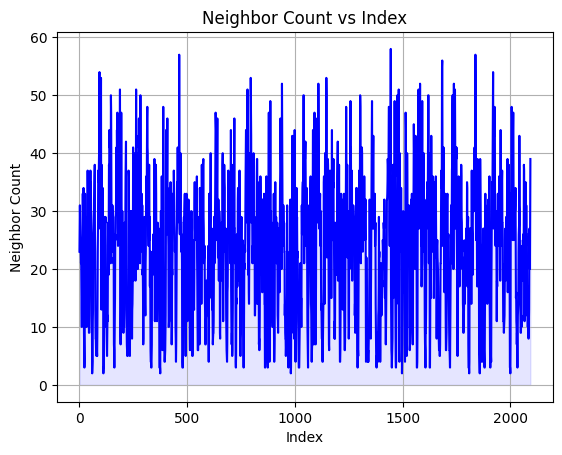

Number of Zero-Length Sublists: 0
[284 494 492 493 440 181 386  92 377 180 179  91 495 378 439 376]
897
897


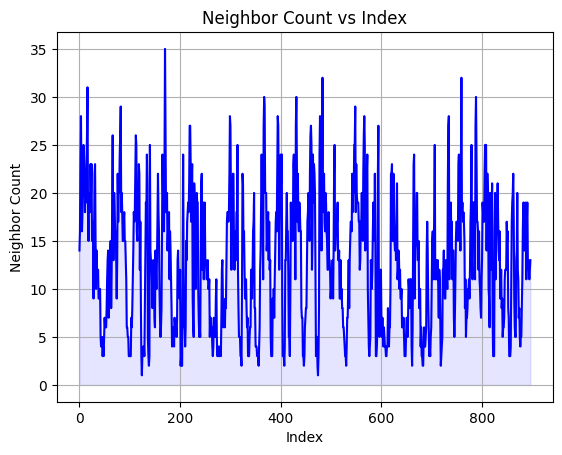

Number of Zero-Length Sublists: 0


In [43]:
def plot_gt(kdtree,data):
    chosen_radius = 1.25

    idx, dists = kdtree.query_radius(data[:],r = chosen_radius, count_only= False, return_distance = True)

    import matplotlib.pyplot as plt
    print(idx[180])

    lengths = []

    count_zeros = 0
    for sublist in idx:
        sublist_len = len(sublist)
        lengths.append(sublist_len)
        if sublist_len < 1:
            count_zeros += 1
    indices = list(range(len(lengths)))
    print(len(indices))
    print(len(lengths))
    plt.plot(indices, lengths, '-b', label='Neighbor Count')  # '-r' means red line
    plt.fill_between(indices, lengths, color='blue', alpha=0.1)  # alpha controls the transparency
    plt.xlabel('Index')
    plt.ylabel('Neighbor Count')
    plt.title('Neighbor Count vs Index')
    plt.grid(True)
    plt.show()
    print(f"Number of Zero-Length Sublists: {count_zeros}")


plot_gt(kdtree_train,train_data)
plot_gt(kdtree_val,val_data)

Calculates the recall at different ranks (N_VALUES) for a set of predictions compared to ground truth values. It iterates through each prediction and checks if the ground truth is within the top N predictions.

In [44]:
N_VALUES = [1,5,10,20]

def getRecallAtN(n_values, predictions, gt):
    correct_at_n = np.zeros(len(n_values))
    numQ = 0
    for qIx, pred in enumerate(predictions):
        if len(gt[qIx]) == 0:
            numQ += 1
            continue

        for i, n in enumerate(n_values):
            # if in top N then also in top NN, where NN > N
            if np.any(np.in1d(pred[1:n+1], gt[qIx])):
                # print("Prediction: ", pred[1:n+1])
                # print("Groundtruth: ", gt[qIx])
                matches = np.in1d(pred[1:n+1], gt[qIx])
                matching_elements = pred[1:n+1][matches]
                correct_at_n[i:] += 1
                break

    return correct_at_n / (len(gt) - numQ)

In [45]:
import random
import math
from scipy import spatial
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(42)
random.seed(42)


class PreProcessing(nn.Module):
    def __init__(self, dim = 4096, margin = 0.7):
        super().__init__() #inherent all pre-existing attributes
        self.model = get_model(dim)

        self.margin = margin
        self.train_loss = list()
        self.valid_loss = list()
        self.acc = list()
        self.largest_val_acc = 0
        self.largest_testing = 0
        self.recall_train_values = list()
        self.recall_val_values = list()



    def forward(self, X):
        X= self.model.pool(X.permute(0,2,1))
        return X


    def testing_predict(self, Xval, Yval, kdtree_val, k_retrieve = K_RETRIEVE): #call this after every epoch
        ## Ytrain, Yval --> GPS coordinates
        Xval = Xval.detach().cpu().numpy().reshape(len(Xval), -1)

        knn_val = KNeighborsClassifier(k_retrieve)
        knn_val.fit(Xval, np.arange(len(Xval))) # validation prediction

        pred_val = knn_val.kneighbors(Xval, 5, return_distance=False)

        ## For validation Recall@K
        val_bar = tqdm(range(len(pred_val)))
        gt_val = []

        for row_idx in val_bar:
            groundtruth_val = np.array(kdtree_threshold(kdtree_val, row_idx, None, Yval, mode="metrics"))
            gt_val.append(groundtruth_val)

        recall_validation = getRecallAtN([5], pred_val, gt_val)
        return recall_validation[0]


    # edited
    def train_model(self, Xtrain, Xval, Ytrain, Yval, kdtree_train, kdtree_val, num_epochs=10, batch_size=16):
        # Initialize optimizer and learning rate scheduler
        optimizer = optim.Adam(self.model.parameters(), lr=5e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=7)

        # Loss function for the triplet margin
        triplet_loss = nn.TripletMarginLoss(margin=self.margin, p=2)
        epochs = 0

        # Create lists of indices for training and validation data, then shuffle training indices
        train_lists = list(range(0, len(Xtrain)))
        val_lists = list(range(0, len(Xval)))
        random.shuffle(train_lists)

        # Initialize tensors to store the model outputs for training and validation data
        forwarded_Xtrain = torch.zeros(len(Xtrain), 4096).to(device)
        forwarded_Xval = torch.zeros(len(Xval), 4096).to(device)

        # Lists to store batch losses for training and validation
        train_batch_loss = list()
        valid_batch_loss = list()

        # Training loop for specified number of epochs
        while epochs <= num_epochs:
            epochs += 1
            print("Epoch: ", epochs)
            random.shuffle(train_lists)  # Shuffle training indices each epoch
            torch.cuda.empty_cache()
            train_progress_bar = tqdm(range(math.ceil(len(train_lists)/batch_size)))

            # Loop over training batches
            for step in train_progress_bar:
                torch.cuda.empty_cache()
                optimizer.zero_grad()
                batch_range = range(batch_size if step < len(train_lists)//batch_size else len(train_lists) % batch_size)

                # Process each training batch
                loss = list()
                for i in batch_range:
                    torch.cuda.empty_cache()
                    selected_idx = train_lists[step*batch_size+i]
                    with torch.no_grad():
                        one_train_set = kdtree_threshold(kdtree_train, selected_idx, Xtrain, Ytrain)

                    # Reshape the training set for model input and calculate loss
                    one_train_set = [s.view(1, 4096, -1) for s in one_train_set]
                    one_train_set = torch.stack([self.forward(set) for set in one_train_set])
                    one_set_loss = triplet_loss(anchor=one_train_set[0], positive=one_train_set[1], negative=one_train_set[2])
                    loss.append(one_set_loss)
                    # Store model output for each training example
                    forwarded_Xtrain[selected_idx] = one_train_set[0]

                # Calculate and store the average training loss for the current batch
                loss = torch.mean(torch.stack(loss))
                train_progress_bar.set_description(f"Training Loss: {loss.item()}")
                train_batch_loss.append(loss)
                loss.backward()
                optimizer.step()

            # Record the average loss over all training batches
            self.train_loss.append(torch.mean(torch.stack(train_batch_loss)))

            # Loop over validation batches
            valid_progress_bar = tqdm(range(math.ceil(len(val_lists)/batch_size)))
            for step in valid_progress_bar:
                torch.cuda.empty_cache()
                optimizer.zero_grad()
                batch_range = range(batch_size if step < len(val_lists)//batch_size else len(val_lists) % batch_size)

                # Process each validation batch
                loss = list()
                for i in batch_range:
                    torch.cuda.empty_cache()
                    selected_idx = val_lists[step*batch_size+i]
                    with torch.no_grad():
                        one_val_set = kdtree_threshold(kdtree_val, selected_idx, Xval, Yval)
                        # Reshape validation set and calculate loss
                        one_val_set = [s.view(1, 4096, -1) for s in one_val_set]
                        one_val_set = torch.stack([self.forward(set) for set in one_val_set])
                        # Store model output for each validation example
                        forwarded_Xval[selected_idx] = one_val_set[0]
                    one_set_loss = triplet_loss(anchor=one_val_set[0], positive=one_val_set[1], negative=one_val_set[2])
                    loss.append(one_set_loss)

                # Calculate and store the average validation loss for the current batch
                loss = torch.mean(torch.stack(loss))
                valid_progress_bar.set_description(f"Validation Loss: {loss.item()}")
                valid_batch_loss.append(loss)

            # Record the average loss over all validation batches
            self.valid_loss.append(torch.mean(torch.stack(valid_batch_loss)))
            scheduler.step(torch.mean(torch.stack(valid_batch_loss)))

            # Calculate and record recall metrics for training and validation sets
            recall_training = self.testing_predict(forwarded_Xtrain, Ytrain, kdtree_train)
            print("Training Recall@5: ", f"{recall_training:.7f}")
            self.recall_train_values.append(recall_training)

            recall_validation = self.testing_predict(forwarded_Xval, Yval, kdtree_val)
            print("Validation Recall@5: ", f"{recall_validation:.7f}")
            self.recall_val_values.append(recall_validation)

            # Update the largest validation accuracy if current accuracy is higher
            if recall_validation >= self.largest_val_acc:
                self.largest_val_acc = recall_validation
            self.acc.append(recall_validation)
            print("Largest Validation Accuracy: ", self.largest_val_acc)



    def plot_results(self):
        import matplotlib.pyplot as plt
        epochs = range(1, len(self.train_loss) + 1)
        print(self.train_loss[0])
        train_loss_np = np.array([t.cpu().detach().numpy() for t in self.train_loss])
        train_loss_np = np.array([t.cpu().detach().numpy() for t in self.train_loss])
        valid_loss_np = np.array([t.cpu().detach().cpu().numpy() for t in self.valid_loss])
        recall_train_values = np.array(self.recall_train_values)
        recall_val_values = np.array(self.recall_val_values)

        # Set up a figure with 3 subplots: (1 row x 3 columns)
        plt.figure(figsize=(18, 5))

        # 1. Val Loss vs Epochs
        plt.subplot(1, 3, 1)
        plt.plot(epochs, train_loss_np, label='Training Loss')
        plt.plot(epochs, valid_loss_np, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss vs. Epochs')

        # 2. val Recall@5 vs Epochs
        plt.subplot(1, 3, 2)
        plt.plot(epochs, recall_val_values, label='Validation Recall@5 vs Epochs', color='blue')
        plt.xlabel('Epochs')
        plt.ylabel('Recall@5')
        plt.legend()
        plt.title('Validation Recall@5 vs. Epochs')

        # 3.
        plt.subplot(1, 3, 3)
        plt.plot(epochs, recall_train_values, label='Training Recall@5', color='green')
        plt.xlabel('Epochs')
        plt.ylabel('Recall@5')
        plt.legend()
        plt.title('Training Recall@5 vs. Epochs')

        plt.tight_layout()
        plt.show()

In [46]:
print(model_val[0].shape)

torch.Size([1, 4096])


In [47]:
def inference(model, Xval, Yval, kdtree_val, k_retrieve = K_RETRIEVE):
    print(Xval[0].shape)
    seq_transposed = Xval[0].transpose(1, 2)
    expanded_seq = seq_transposed.repeat(1, 3, 1)
    print(expanded_seq.shape)  # should print (5, 3, 4096)
    Xval_fw = torch.stack([model.pool(s.transpose(1, 2).repeat(1, 3, 1)) for s in Xval]).view(len(Xval), -1)


    Xval_fw = Xval_fw.detach().cpu().numpy().reshape(len(Xval), -1)

    knn_val = KNeighborsClassifier(k_retrieve)
    knn_val.fit(Xval_fw, np.arange(len(Xval))) # validation prediction

    pred_val = knn_val.kneighbors(Xval_fw, 5, return_distance=False)

    ## For validation Recall@K
    val_bar = tqdm(range(len(pred_val)))
    gt_val = []

    for row_idx in val_bar:
        groundtruth_val = np.array(kdtree_threshold(kdtree_val, row_idx, None, Yval, mode="metrics"))
        gt_val.append(groundtruth_val)

    recall_validation = getRecallAtN([5], pred_val, gt_val)
    return recall_validation[0]

In [48]:
SeqNet = get_model(4096)

In [49]:
val_score = inference(SeqNet, model_val_tensor, val_data, kdtree_val)

torch.Size([5, 4096, 1])
torch.Size([5, 3, 4096])


100%|██████████| 897/897 [00:00<00:00, 2415.43it/s]


In [50]:
print(val_score)

0.835005574136009


In [51]:
torch.cuda.empty_cache()
SeqNet = PreProcessing(dim = 4096, margin = 1.2)
SeqNet.train_model(model_train_tensor, model_val_tensor, train_data, val_data, kdtree_train,  kdtree_val, batch_size = batch_size, num_epochs = num_epochs)

Epoch:  1


100%|██████████| 2094/2094 [00:01<00:00, 1964.57it/s]


Training Recall@5:  0.6442216


100%|██████████| 897/897 [00:00<00:00, 3230.79it/s]


Validation Recall@5:  0.7647715
Largest Validation Accuracy:  0.7647714604236343
Epoch:  2


100%|██████████| 2094/2094 [00:00<00:00, 2247.07it/s]


Training Recall@5:  0.7612225


100%|██████████| 897/897 [00:00<00:00, 3572.99it/s]


Validation Recall@5:  0.7670011
Largest Validation Accuracy:  0.7670011148272018
Epoch:  3


100%|██████████| 2094/2094 [00:00<00:00, 2282.39it/s]


Training Recall@5:  0.8099331


100%|██████████| 897/897 [00:00<00:00, 3651.78it/s]


Validation Recall@5:  0.7591973
Largest Validation Accuracy:  0.7670011148272018
Epoch:  4


100%|██████████| 2094/2094 [00:00<00:00, 2234.52it/s]


Training Recall@5:  0.8022923


100%|██████████| 897/897 [00:00<00:00, 3304.61it/s]


Validation Recall@5:  0.7558528
Largest Validation Accuracy:  0.7670011148272018
Epoch:  5


100%|██████████| 2094/2094 [00:00<00:00, 2189.43it/s]


Training Recall@5:  0.8304680


100%|██████████| 897/897 [00:00<00:00, 2477.18it/s]


Validation Recall@5:  0.7614270
Largest Validation Accuracy:  0.7670011148272018
Epoch:  6


100%|██████████| 2094/2094 [00:01<00:00, 1647.81it/s]


Training Recall@5:  0.8357211


100%|██████████| 897/897 [00:00<00:00, 2365.15it/s]


Validation Recall@5:  0.7569677
Largest Validation Accuracy:  0.7670011148272018
Epoch:  7


100%|██████████| 2094/2094 [00:01<00:00, 1770.36it/s]


Training Recall@5:  0.8338109


100%|██████████| 897/897 [00:00<00:00, 3773.02it/s]


Validation Recall@5:  0.7647715
Largest Validation Accuracy:  0.7670011148272018
Epoch:  8


100%|██████████| 2094/2094 [00:00<00:00, 2423.26it/s]


Training Recall@5:  0.8624642


100%|██████████| 897/897 [00:00<00:00, 3377.95it/s]


Validation Recall@5:  0.7647715
Largest Validation Accuracy:  0.7670011148272018
Epoch:  9


100%|██████████| 2094/2094 [00:00<00:00, 2403.03it/s]


Training Recall@5:  0.8734479


100%|██████████| 897/897 [00:00<00:00, 3690.00it/s]


Validation Recall@5:  0.7647715
Largest Validation Accuracy:  0.7670011148272018
Epoch:  10


100%|██████████| 2094/2094 [00:00<00:00, 2210.17it/s]


Training Recall@5:  0.8701051


100%|██████████| 897/897 [00:00<00:00, 3563.36it/s]


Validation Recall@5:  0.7603122
Largest Validation Accuracy:  0.7670011148272018
Epoch:  11


100%|██████████| 2094/2094 [00:00<00:00, 2340.58it/s]


Training Recall@5:  0.8858644


100%|██████████| 897/897 [00:00<00:00, 3138.71it/s]


Validation Recall@5:  0.7569677
Largest Validation Accuracy:  0.7670011148272018


tensor(0.2153, device='cuda:0', grad_fn=<MeanBackward0>)


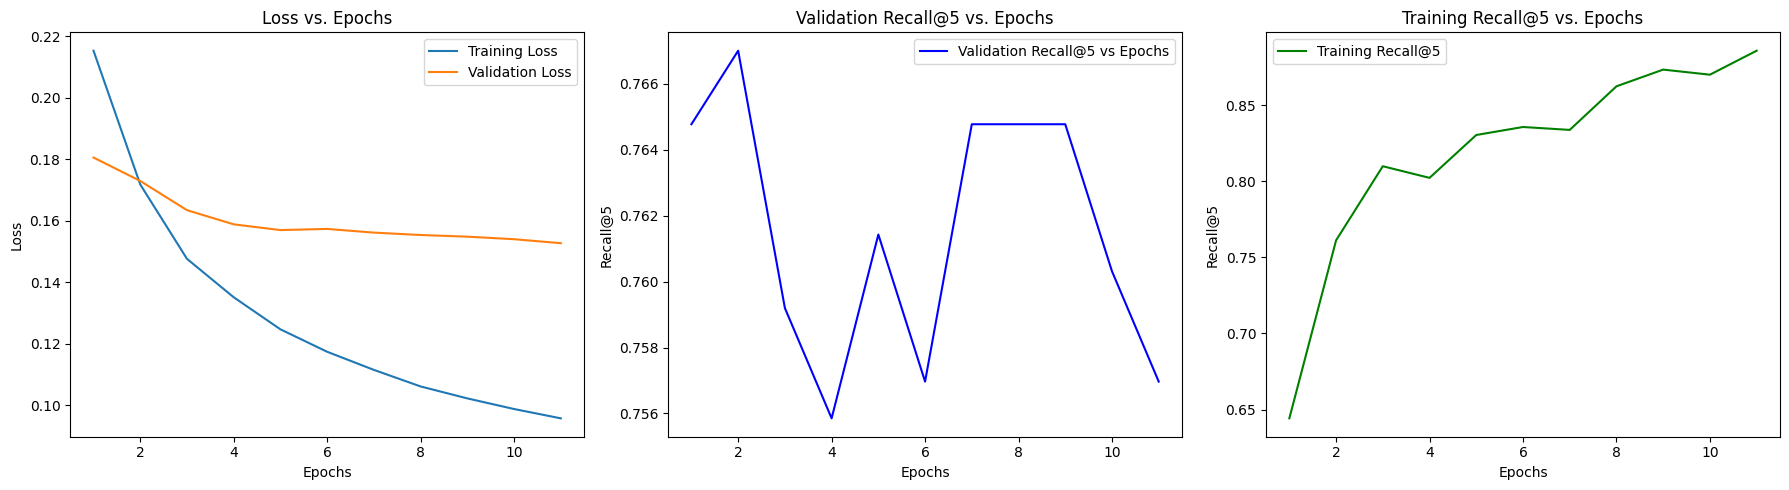

In [52]:
SeqNet.plot_results()